# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [40]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [41]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. 
# The data is about 53MB so this cell should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='./p1_dataset/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and 
# the number of data points and apply this permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, 
# resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

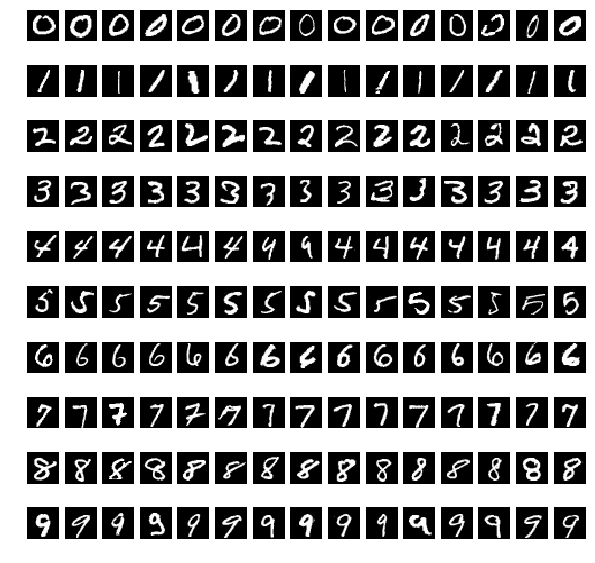

In [5]:
def P1(num_examples,labels,data):
    plot_list = []
    for i in range(10):
        j=0
        plot_list.append([])
        while len(plot_list[i]) < num_examples:
            if labels[j] == i:
                plot_list[i].append(data[j])
            j +=1
    plt.figure(figsize=(10,10))
    for i in range(len(plot_list)):
        for j in range(num_examples):
            plt.subplot(len(plot_list),num_examples,(i*num_examples)+j+1)
            pixels = plot_list[i][j]    
            pixels = pixels.reshape((28,28))
            plt.imshow(pixels, cmap='gray')
            plt.axis('off')
    plt.show()

P1(15,mini_train_labels,mini_train_data)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [12]:
def P2(k_values):
    dev_pred_labels = []
    for index,k in enumerate(k_values):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(mini_train_data, mini_train_labels)
        dev_pred_labels.append(model.predict(dev_data))
        wrong_pred = (dev_pred_labels[index] != dev_labels)
        accuracy = 1-np.sum(wrong_pred)/len(wrong_pred)
        print('\nAccuracy of k =', k, ':', '%.2f'%accuracy)
    label_name=['0','1','2','3','4','5','6','7','8','9']
    
    report = classification_report(dev_labels, dev_pred_labels[0], target_names=label_name)
    return report 


k_values = [1, 3, 5, 7, 9]
print('\nPrecision, recall and F1 score of k=1 nearest neighbor model\n',P2(k_values))


Accuracy of k = 1 : 0.89

Accuracy of k = 3 : 0.88

Accuracy of k = 5 : 0.87

Accuracy of k = 7 : 0.86

Accuracy of k = 9 : 0.86

Precision, recall and F1 score of k=1 nearest neighbor model
              precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [14]:
def P3(train_sizes, accuracies):
    """
    This function trains a Nearest Neighbor model on the training set.
    The list of different sizes of training set can be defined during 
    input, and the function returns a list of accuracies of each 
    different training size.
    The function also shows the prediction time for different training 
    sizes defined.
    """
    pred_labels = []
    label_name=['0','1','2','3','4','5','6','7','8','9']
    for index,size in enumerate(train_sizes):
        model = KNeighborsClassifier(n_neighbors=1)
        model.fit(train_data[:size], train_labels[:size])
        start_time = time.time()
        pred_labels.append(model.predict(dev_data))
        end_time = time.time()
        wrong_pred = (pred_labels[index] != dev_labels)
        accuracies.append(1-np.sum(wrong_pred)/len(wrong_pred))
        pred_time = end_time - start_time
        print('The time that takes to predict dev_labels with training size ', size, 'is', '%.2f'%pred_time, 'seconds.' )
    accuracies = [ '%.2f' % e for e in accuracies ]
    return accuracies


train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
print('\nThe different training sizes:\n', train_sizes)
print('\nThe accuracies of different training size:\n', P3(train_sizes, accuracies))


The different training sizes:
 [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
The time that takes to predict dev_labels with training size  100 is 0.14 seconds.
The time that takes to predict dev_labels with training size  200 is 0.27 seconds.
The time that takes to predict dev_labels with training size  400 is 0.54 seconds.
The time that takes to predict dev_labels with training size  800 is 1.11 seconds.
The time that takes to predict dev_labels with training size  1600 is 2.24 seconds.
The time that takes to predict dev_labels with training size  3200 is 4.47 seconds.
The time that takes to predict dev_labels with training size  6400 is 9.09 seconds.
The time that takes to predict dev_labels with training size  12800 is 18.41 seconds.
The time that takes to predict dev_labels with training size  25000 is 36.24 seconds.

The accuracies of different training size:
 ['0.72', '0.79', '0.84', '0.88', '0.90', '0.93', '0.94', '0.96', '0.97']


From the output we see that the time that takes the prediction to run grows proportional to the training size with a O(n) complexity. The accuracy gets better when a larger training size is used.

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [8]:
def P4():


P4()

ANSWER:

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

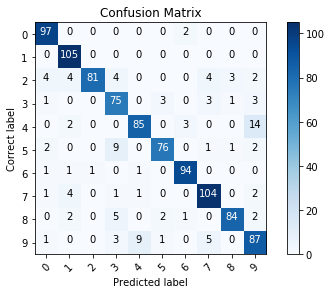

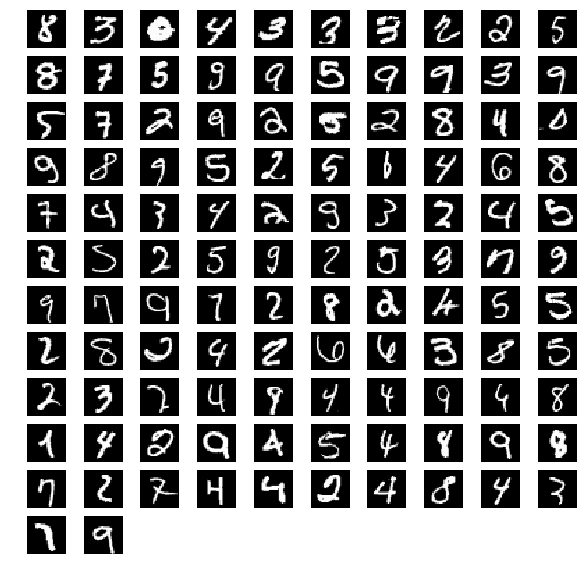

In [37]:
def P5():
    """
    This function fits a Nearest Neighbor model, creates
    predicted labels given the dev dataset and plots the
    confusion matrix comparing the correct labels and the
    predicted labels. 
    The cases where prediction is wrong are then plotted.
    """
    label_names=['0','1','2','3','4','5','6','7','8','9']
    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(mini_train_data, mini_train_labels)
    pred_labels = model.predict(dev_data)
    cnf_matrix = confusion_matrix(dev_labels, pred_labels)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=label_names)
    wrong = (dev_labels != pred_labels)
    wrong_cases = dev_data[wrong]
    shuffle = np.random.permutation(len(wrong_cases))
    wrong_cases = wrong_cases[shuffle]
    wrong_cases_examples = wrong_cases[:10] # if there're too many wrong cases
    
    plt.figure(figsize=(10,10))
    for i in range(len(wrong_cases)):
            plt.subplot(int(len(wrong_cases)/10)+(len(wrong_cases)%10>0),10,i+1)
            pixels = wrong_cases[i]    
            pixels = pixels.reshape((28,28))
            plt.imshow(pixels, cmap='gray')
            plt.axis('off')
    plt.show()


def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix in color map.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Predicted label')
    
    
P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

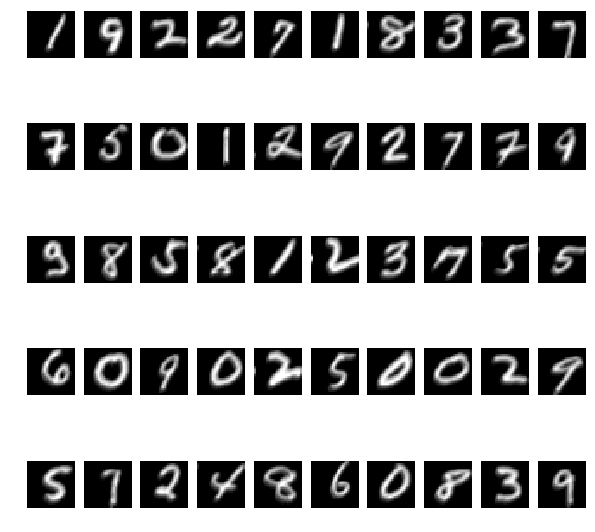


The accuracies of prediction using unweighted mini-training data model and original dev data:
              precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000


The accuracies of prediction using unweighted mini-training data model and weighted dev data:
              precision    recall  f1-score   support

          0       0.65      0.60      0.62        99
          1       0.41      0.73      0.53       105
         

In [86]:
def P6():
    """
    This function compares the accuracies between models trained by 
    blurred digit image v.s. original digit image. Several examples
    of the blurred digit images in the training set are plotted.
    """
    label_names = ['0','1','2','3','4','5','6','7','8','9']
    ## Create the weighted image dataset
    weighted_mini_train_data = GaussianFilter(mini_train_data, 1)
    weighted_dev_data = GaussianFilter(dev_data, 1)
    
    ## Pick 50 random images in the mini training set and plot it
    plt.figure(figsize=(10,10))
    image_examples = weighted_mini_train_data[:50]
    for i in range(50):
        plt.subplot(5,10,i+1)
        pixels = image_examples[i]
        pixels = pixels.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.axis('off')
    plt.show()
    
    ## Create 2 models: one with original training image data, 
    ## the other with weighted training image data
    model1 = KNeighborsClassifier(n_neighbors=1)
    model1.fit(mini_train_data, mini_train_labels)
    model2 = KNeighborsClassifier(n_neighbors=1)
    model2.fit(weighted_mini_train_data, mini_train_labels)
    
    ## prediction of unweighted model with dev data
    pred_labels_mod1_dev = model1.predict(dev_data)
    report1 = classification_report(dev_labels, pred_labels_mod1_dev, 
                                    target_names=label_names)
    print('\nThe accuracies of prediction using unweighted mini-training data model', 
          'and original dev data:\n', report1)
    
    ## prediction of unweighted model with weighted dev data    
    pred_labels_mod1_weighted_dev = model1.predict(weighted_dev_data)
    report2 = classification_report(dev_labels, pred_labels_mod1_weighted_dev, 
                                    target_names=label_names)
    print('\nThe accuracies of prediction using unweighted mini-training data model', 
          'and weighted dev data:\n', report2)
    
    ## prediction of weighted model with dev data
    pred_labels_mod2_dev = model2.predict(dev_data)
    report3 = classification_report(dev_labels, pred_labels_mod2_dev, 
                                    target_names=label_names)
    print('\nThe accuracies of prediction using weighted mini-training data model', 
          'and original dev data:\n', report3)
    
    ## prediction of weighted model with weighted dev data
    pred_labels_mod2_weighted_dev = model2.predict(weighted_dev_data)
    report4 = classification_report(dev_labels, pred_labels_mod2_weighted_dev, 
                                    target_names=label_names)
    print('\nThe accuracies of prediction using weighted mini-training data model', 
          'and weighted dev data:\n', report4)
    
def GaussianFilter(data,blur_size=1):
    """
    This function takes an image dataset as input and applies a simple 
    gaussian filter to blur the image. The filter works as a moving 
    weighted average for every pixel in the image. Blur size represents 
    how many pixels away does the filtering take into weighting consideration.
    The higher the blur_size, the higher the blurring effect. The list of 
    blurred image are returned as output.
    """
    ## Set the moving average diameter
    d = blur_size*2 + 1
    weighted_data = []
    
    ## Iterate through all the images in the dataset 
    for image_index, image in enumerate(data):
        weighted_data.append([])
        
        ## Iterate through all the pixels in each image
        for pixel_index, pixel in enumerate(image):
            x = (pixel_index % 28) - 1 + (pixel_index % 28 == 0)*28 
            y = int(pixel_index / 28) 
            total_weight = 0
            pix_sum = 0
            
            ## Moving weighted average filter
            ## Get the location of the neighbor pixel
            for i in range(d**2):
                ix = (i%d) - 1 + (i%d == 0)*d
                iy = int(i/d) + (i%d > 0)
                absx = x + ix - blur_size
                absy = y + iy - blur_size
                
                ## Weight is set by the absolute distance between 
                ## the neighbor and the pixel in focus
                weight = int( ( (ix - blur_size)**2 + (iy - blur_size)**2 )**(1/2) )
                
                ## Set the value out of image range to be 0
                ## Calculate the weighted pixel value
                if absx < 0 or absy < 0 or absx > 27 or absy > 27:
                    val = 0
                    weight = 0
                else:
                    val = image[ (absy*28) - 1 + (absx%28) + (absx%28 == 0)*28 ] * weight
                pix_sum += val
                total_weight += weight
            weighted_data[image_index].append(pix_sum/total_weight)
        weighted_data[image_index] = np.array(weighted_data[image_index])
    return weighted_data
                    

P6()

ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [115]:
def P7():
    """
    This function fits a Bernoulli Naive Bayes model using 
    binarized mini training data and fits a Multinomial 
    Naive Bayes model using training images with values either
    0, 1 or 2. The prediction accuracy on the dev dataset
    are compared.
    """    
    ## Find the average image pixel intensity 
    pic_sum = 0
    for i in range(len(mini_train_data)):
        pic_sum += np.mean(mini_train_data)
    threshold = sum/len(mini_train_data)
    
    ## Create new binarized mini training and dev data
    binarized_mini_train_data = binarize_image(mini_train_data)
    binarized_dev_data = binarize_image(dev_data)
    
    ## Fit a Bernoulli Naive Bayes model using binarized mini training data
    ## = BernoulliNB(alpha=1)
    ##.fit(binarized_mini_train_data, mini_train_labels)
    
    ## Create new mini training and dev data where pixel intensity is either 0, 1 or 2
    leveled_mini_train_data = levelize_image(mini_train_data,threshold)
    leveled_dev_data = levelize_image(dev_data,threshold)
    
    ## 
    #MultinomialNB()
    #.fit
    #print(binarized_mini_train_data[:2])    
    #print(leveled_mini_train_data[:2])
    
def binarize_image(data):
    """
    This function binarize the pixel values of the images 
    """
    ## Initialize an array with the same shape as the original data
    binarized_data = np.zeros(data.shape)
    ## If the pixel value is not 0 --> give it 1
    for pixel in range(data.shape[1]):
        binarized_data[:,pixel] = data[:,pixel] > 0
    return binarized_data

def levelize_image(data, threshold):
    """
    This function map the pixel values of the images to 0, 1 or 2 
    """
    ## Initialize an array with the same shape as the original data
    leveled_data = np.zeros(data.shape)

    ## Assign pixel value 2 if above threshold and 1 if value below threshold but above 0. 
    ## Pixels with no value are 0
    for pixel in range(data.shape[1]):
        ##print( (data[:,pixel]>threshold)*2) 
        ##print( ( (data[:,pixel]>0) and (data[:,pixel]<threshold) ) )
        above_threshold = [int(i)*2 for i in (data[:,pixel]>threshold)]
        above0 = [int(i) for i in (data[:,pixel]>0 and data[:,pixel]<threshold)]
        leveled_data[:,pixel] = above_threshold and above0
    print(above_threshold, above0)
    print(leveled_data[:1])
    return leveled_data


P7()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [119]:
## Find the average image pixel intensity 
sum = 0
for i in range(len(mini_train_data)):
    sum += np.mean(mini_train_data)
threshold = sum/len(mini_train_data)


g = [int(i)*2 for i in ([True, True, False] and [False, True, False]) ]
f = [int(i)*2 for i in ([True, True, False] and [False, False, False]) ]
print(g,f)
print(g and f)
for pixel in range(mini_train_data.shape[1]):
    above0 = [( (mini_train_data[:,pixel]>0) and (mini_train_data[:,pixel]<threshold) )]
print(above0)


[0, 2, 0] [0, 0, 0]
[0, 0, 0]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ANSWER:

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [12]:
#def P8(alphas):

### STUDENT START ###



### STUDENT END ###

#alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
#nb = P8(alphas)

In [14]:
#print nb.best_params_

ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [15]:
#def P9():

### STUDENT END ###


### STUDENT END ###

#gnb = P9()

ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [16]:
#def P10(num_examples):

### STUDENT START ###


### STUDENT END ###

#P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [17]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()